In [1]:
import numpy as np 
from scipy.stats import norm as Norm
from pymc3 import Model, sample, Normal, Uniform, model_to_graphviz, plot_posterior, trace_to_dataframe

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'


In [2]:
# -- plotting --
import matplotlib as mpl 
import matplotlib.pyplot as plt 
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False
%matplotlib inline

In [3]:
theta_hyper = np.array([0., 1.]) # mean and variance of the true population
mu_dist = Norm(loc=theta_hyper[0], scale=theta_hyper[1])
mu_samp = mu_dist.rvs(size=1000)

# add some noise
alpha = 1. 
xs = mu_samp + alpha * np.random.normal(size=len(mu_samp))

Toy example where we have some physical parameter $\mu$ that comes from a Gaussian distribution defined by hyperparameters $\theta = \{\theta_\mu, \theta_\sigma\}$. 
$$\mu \sim \mathcal{N}(\theta_\mu, \theta_\sigma)$$
Of course, we don't directly observe $\mu$. We observe $x$, which in the toy example will just be a noisy measurement of $\mu$. 
$$x \sim \mathcal{N}(\mu, \alpha = 1.)$$
In a more realistic example, $\mu$ can be $M_*$ and $\theta$ can be Schecter function parameters. $x$ would in that case be a galaxy spectrum. 

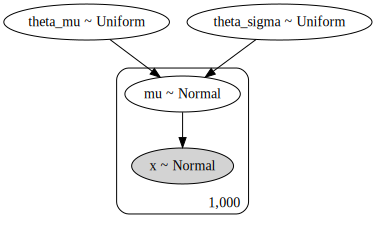

In [4]:
with Model() as partial_pooling:

    # Priors
    theta_mu = Uniform('theta_mu', lower=-5., upper=5.)
    theta_sig = Uniform('theta_sigma', lower=0., upper=2.)

    # Random intercepts
    mu = Normal('mu', mu=theta_mu, sigma=theta_sig, shape=1000)

    # Model error
    #alpha = 1.#Uniform('alpha', lower=0.5, upper=1.5)

    # Data likelihood
    x = Normal('x', mu=mu, sigma=alpha, observed=xs)

model_to_graphviz(partial_pooling)

(-5, 5)

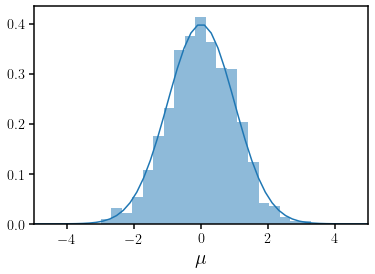

In [5]:
fig = plt.figure()
sub = fig.add_subplot(111)
sub.hist(mu_samp, bins=20, density=True, color='C0', alpha=0.5)
sub.plot(np.linspace(-10., 10, 100), mu_dist.pdf(np.linspace(-10., 10, 100)))
sub.set_xlabel('$\mu$', fontsize=20)
sub.set_xlim(-5, 5)

In the most general case, we'll the posterior $p(\mu_i | x_i)$ for each object. In the realistic case, this will be the posteriors $p(M_*|{\rm spectrum})$. 

In our toy example, since $x \sim \mathcal{N}(\mu, \alpha = 1.)$, $p(\mu_i | x_i)$ is just a Gaussian of width $\alpha$ centered around $x_i$. 

In [6]:
mu_post = np.zeros((len(xs), 100)) 
for i, x in enumerate(xs): 
    _norm = Norm(loc=x, scale=alpha)
    mu_post[i,:] = _norm.rvs(size=100)

(-5, 5)

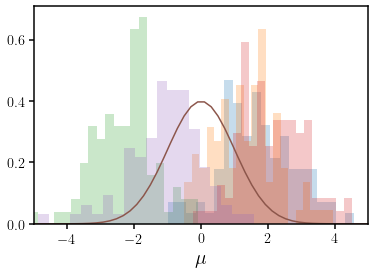

In [7]:
fig = plt.figure()
sub = fig.add_subplot(111)
for i in range(5): 
    sub.hist(mu_post[i,:], bins=20, density=True, alpha=0.25)
#sub.hist(mu_samp, bins=20, density=True, color='C0', alpha=0.5)
sub.plot(np.linspace(-10., 10, 100), mu_dist.pdf(np.linspace(-10., 10, 100)))
sub.set_xlabel('$\mu$', fontsize=20)
sub.set_xlim(-5, 5)

Here's what happens if we do what is typically done --- i.e. treating the median of the posterior as point estimates of $\mu$. This is equivalent to taking the median of each posterior $p(\mu_i|x_i)$. Here's how the PDF of $\mu$ looks with this *incorrect* method. 

(-5, 5)

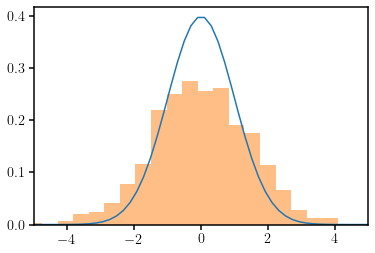

In [8]:
fig = plt.figure()
sub = fig.add_subplot(111)
sub.hist(np.median(mu_post, axis=1), bins=20, density=True, color='C1', alpha=0.5)
sub.plot(np.linspace(-10., 10, 100), mu_dist.pdf(np.linspace(-10., 10, 100)))
sub.set_xlim([-5, 5])

Lets be more qualitative, how does this impact the posteriors of hyperpameters $\theta_\mu$ and $\theta_\sigma$, which is what we're ultimately interested in. 

In [9]:
import emcee
import corner
mu_pt = np.median(mu_post, axis=1)

def lnprior(tt): 
    tt0, tt1 = tt
    if (-10. < tt0 < 10.) and (0. < tt1 < 2.): 
        return 0. 
    return -np.inf

def lnlike(tt): 
    return -0.5 * np.sum((tt[0] - mu_pt)**2)/tt[1]**2 - (float(len(mu_pt)) * np.log(tt[1]))

def lnprob(tt): 
    lp = lnprior(tt)
    if not np.isfinite(lp): 
        return -np.inf
    return lp + lnlike(tt)

ndim, nwalkers = 2, 100
pos = [np.array([0., 1.]) + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob)
sampler.run_mcmc(pos, 500)

(array([[ 3.49353932e-02,  1.41741940e+00],
        [-6.50260617e-02,  1.38848555e+00],
        [-1.35708557e-02,  1.41616341e+00],
        [-4.18664512e-02,  1.40310696e+00],
        [-4.29749475e-02,  1.43641490e+00],
        [ 4.45421106e-03,  1.38813621e+00],
        [-5.07017820e-02,  1.41457165e+00],
        [ 1.51995521e-02,  1.40812094e+00],
        [ 5.47848598e-02,  1.40090171e+00],
        [-4.06286292e-02,  1.40269420e+00],
        [-4.03143373e-02,  1.42058860e+00],
        [ 1.12160731e-01,  1.43850866e+00],
        [-2.34495945e-02,  1.40375900e+00],
        [-5.84295194e-02,  1.33773373e+00],
        [-1.74718672e-02,  1.41221423e+00],
        [ 1.74341094e-03,  1.37033977e+00],
        [ 2.32179441e-02,  1.46692113e+00],
        [ 7.70272583e-02,  1.39021690e+00],
        [ 1.13210878e-01,  1.39041319e+00],
        [-1.79199066e-02,  1.41139090e+00],
        [ 1.15828831e-02,  1.45950942e+00],
        [ 5.51737800e-02,  1.38316178e+00],
        [-7.85882443e-02,  1.423

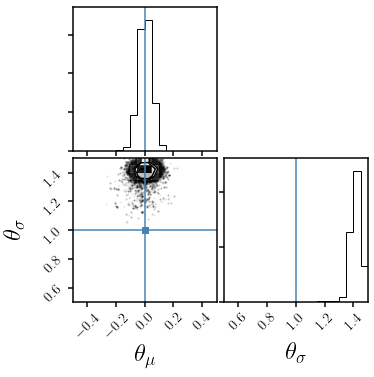

In [23]:
samples = sampler.chain[:, 50:, :].reshape((-1, ndim))
import corner
fig = corner.corner(samples, labels=[r"$\theta_\mu$", r"$\theta_\sigma$"], label_kwargs={'fontsize': 25}, truths=[0., 1.], range=[(-0.5, 0.5), (0.5, 1.5)])

Instead, we can use hierarchical bayesian models to infer the posteriors of $\theta_\mu$ and $\theta_\sigma$ given $\{x_i\}$. 
$$p(\theta|\{x_i\}) \propto p(\{x_i\}|\theta) p(\theta)$$
where the likelihood of the hyperparameters can be written 
$$p(\{x_i\} | \theta) = p(\{x_i\} | \alpha)\int \frac{p(\{\mu_i\}|\theta)}{p(\{\mu_i\}|\alpha)} p(\{\mu_i\}|\{x_i\}, \alpha) d\{\mu_i\}$$

In our toy example this is, I think 
$$p(\{x_i\} | \theta) = \int p(\{\mu_i\}|\theta) p(\{\mu_i\}|\{x_i\}, \alpha) d\{\mu_i\}$$
The integration can be evaluated using importance sampling 
$$p(\{x_i\} | \theta) = \sum\limits_{\{\mu_i\}^{(n)}; n=1}^{N} p(\{\mu_i\}^{(n)}|\theta)$$
where $\{\mu_i\}^{(n)}$ is sampled from the posterior $p(\{\mu_i\} | \{x_i\})$. 

For this toy example it's easy to use pymc to sample everything!

In [12]:
with partial_pooling:
    partial_pooling_trace = sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, theta_sigma, theta_mu]
Sampling 4 chains: 100%|██████████| 8000/8000 [00:09<00:00, 807.97draws/s] 


In [15]:
hdm_samples = np.array([partial_pooling_trace['theta_mu'], partial_pooling_trace['theta_sigma']]).T

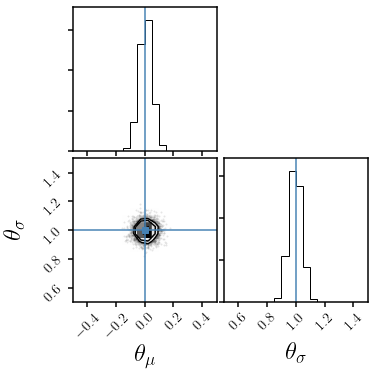

In [22]:
fig = corner.corner(hdm_samples, labels=[r"$\theta_\mu$", r"$\theta_\sigma$"], label_kwargs={'fontsize': 25}, truths=[0., 1.], range=[(-0.5, 0.5), (0.5, 1.5)])